In [4]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from torchvision import transforms, utils
import torch.nn.functional as F
import time
import json
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

##### View image

width: 124 height: 127


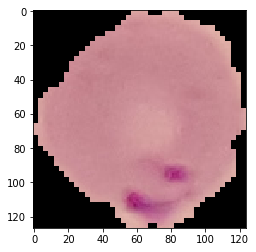

width: 145 height: 178


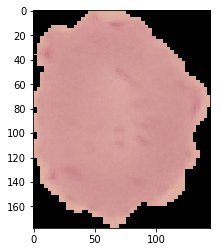

In [10]:
### Open 1 Parasitized and 1 uninfected image
from PIL import Image
import matplotlib.image as mpimg
def image_loader(img):
    im = Image.open(img, 'r')
    width, height = im.size
    pixel_values = list(im.getdata())
    print("width:",width,"height:",height)
    img = mpimg.imread(img)
    plt.imshow(img)
    plt.show()
    
image_loader('Parasitized/C99P60ThinF_IMG_20150918_142334_cell_9.png')
image_loader('Uninfected/C99P60ThinF_IMG_20150918_142128_cell_56.png')

##### Loading dataset and preprocessing

In [12]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(root="/home/dd901/resNet",transform=train_transform)

######## find mean of all the pix
image_means = torch.stack([t.mean(1).mean(1) for t, c in train_dataset])
mean_image=image_means.mean(0)

######## find standard deviation
image_sds = torch.stack([t.std(1).std(1) for t, c in train_dataset])
sd_image=image_sds.std(0)

In [13]:
##### function to load train, valid, test data from the image directory.

def train_valid_test_loader(img_dir,
                            batch_size,
                            random_seed,
                            train_size=0.6, 
                            valid_test_ratio=0.5, 
                            shuffle=True,
                            num_workers=4,
                            pin_memory=False):
    
    

    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(180),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_image,sd_image)])
   
    
    train_dataset = datasets.ImageFolder(root=img_dir,transform=train_transform)
    
    ########splitinng data set into train, valid, test
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor((train_size * num_train)))
    valid_split = int(np.floor((num_train-split)*valid_test_ratio))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx = indices[:split]
    valid_idx = indices[split:(split+valid_split)]
    test_idx = indices[(split+valid_split):]
    
    print("train:",len(train_idx),"valid:",len(valid_idx),"test:", len(test_idx))
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, 
                    sampler=valid_sampler,num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(train_dataset, batch_size=batch_size, 
              sampler=test_sampler, num_workers=num_workers,pin_memory=pin_memory)

    
    
    return (train_loader, valid_loader, test_loader)

Train data, validation data, test data

In [14]:
img_dir='./cell_images/'

train_loader, valid_loader,test_loader\
=train_valid_test_loader('./cell_images/',64,random_seed=42,pin_memory=True)

train: 16534 valid: 5512 test: 5512


Targets have level 0, 1 and the input data is 180X180 pixels where each pixel has 3 numbers corresponding to R G B

In [15]:
for batch_idx, (data, target) in enumerate(test_loader):
    print(target.shape,data.shape)
    #plt.imshow(data)
    break

torch.Size([64]) torch.Size([64, 3, 180, 180])


### Model

 The model is based on ResNeXt50 with minor modifications

In [7]:
from model import ResNeXt50
cardinality=64
depth=32
nlabels=2
base_width=4
widen_factor=4
net = ResNeXt50(cardinality, depth, nlabels, base_width, widen_factor)
#print(net)

In [17]:
torch.cuda.current_device(),torch.cuda.device_count()

(0, 1)

In [8]:
net = torch.nn.DataParallel(net, device_ids=[0])
net.cuda()

In [19]:
decay=0.9
optimizer = torch.optim.Adam(net.parameters(),lr=0.0005)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=decay)

##### Validation code

In [20]:
import copy
best_model_state_dict = copy.deepcopy(net.state_dict())
def callback():
    net.eval()
    Nvalcount=0
    valid_loss = 0
    valid_acc=0
    Nbatchcount=0
    for batch_idx, (data, target) in enumerate(valid_loader):
        
        data = torch.autograd.Variable(data.cuda())
        target = torch.autograd.Variable(target.cuda())
        

        with torch.no_grad():
            pred = net(data)
            loss = F.cross_entropy(pred, target)
            
            pred = pred.data.max(1)[1]
            valid_acc += float(pred.eq(target.data).sum())

            valid_loss += float(loss)
            Nvalcount += len(data)
            Nbatchcount += 1
            
    
    state['valid_loss'] = valid_loss / Nbatchcount
    state['valid_accuracy'] = valid_acc / Nvalcount
           
    if (valid_acc / Nvalcount) > best_accuracy[0]: 
        best_accuracy[0] = valid_acc / Nvalcount
        print("Best accuracy: %f" % best_accuracy[0])
        best_model_state_dict[0] = net.state_dict()
       # with open("malaria_model.pytorch", 'wb') as f:
        #    torch.save(best_model_state_dict[0], f)
        torch.save(net.state_dict(),"malaria_model.pytorch")

##### Training

In [21]:
state={}
best_accuracy = [-np.inf]
epochs=10
step_size=0.005

for epoch in range(epochs):
    t0 = time.time()
    print("epoch started")
    print("---------------------------")
    print("epoch = %d" % epoch)
    print("step_size = %.4f" % step_size)
    train_loss=0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        optimizer.zero_grad()
        
        data = torch.autograd.Variable(data.cuda())
        target = torch.autograd.Variable(target.cuda())
        print('minibatch',batch_idx+1,'/',int(len(train_loader)), end='\r')
        
        pred = net(data)
        loss = F.cross_entropy(pred, target)
        loss.backward()
        optimizer.step()
        t1 = time.time() 
        train_loss = train_loss * 0.2 + float(loss) * 0.8
        
    state['train_loss'] = train_loss
    callback()
    print("Epoch took {} seconds".format(t1-t0)) 
    print(state)
    print()
    scheduler.step()
    step_size = step_size * decay
        
    

epoch started
---------------------------
epoch = 0
step_size = 0.0050
Best accuracy: 0.855406
Epoch took 213.18257689476013 seconds
{'train_loss': 0.39168827738125106, 'valid_loss': 0.3473680341380766, 'valid_accuracy': 0.8554063860667634}

epoch started
---------------------------
epoch = 1
step_size = 0.0045
Epoch took 211.32027220726013 seconds
{'train_loss': 0.22767767306804687, 'valid_loss': 0.36788473252592413, 'valid_accuracy': 0.8461538461538461}

epoch started
---------------------------
epoch = 2
step_size = 0.0041
Best accuracy: 0.858309
Epoch took 211.42372751235962 seconds
{'train_loss': 0.5237046591789186, 'valid_loss': 0.3196588809462799, 'valid_accuracy': 0.8583091436865021}

epoch started
---------------------------
epoch = 3
step_size = 0.0036
Best accuracy: 0.861938
Epoch took 209.7875781059265 seconds
{'train_loss': 0.39448099829008954, 'valid_loss': 0.326106211406061, 'valid_accuracy': 0.8619375907111756}

epoch started
---------------------------
epoch = 4
step_s

### Testing model

##### Reading model file

In [22]:
with open('malaria_model.pytorch', 'rb') as f:
     state_dict = torch.load(f)

##### Computing output probabilities 

In [23]:
from model import ResNeXt50
net = ResNeXt50(cardinality, depth, nlabels, base_width, widen_factor)
net = torch.nn.DataParallel(net, device_ids=[0])
net.load_state_dict(state_dict)
net.eval()


ytrue=[]
ypred=[]
for batch_idx, (data, target) in enumerate(test_loader):
    ytrue.append(target)
    data = torch.autograd.Variable(data.cuda())
    target = torch.autograd.Variable(target.cuda())
    with torch.no_grad():
        pred = net(data)
        ypred.append(pred)

In [25]:
#print(ytrue[0]), print(ypred[0])

##### Compute accuracy 

In [27]:
##########Flatten the true classes array in (0,1,....)
ytrue=np.array([label for tensor in ytrue for label in tensor])


ypred=[float(entry) for sublist in ypred for val in sublist for entry in val]
ypred=np.array(ypred).reshape(len(ytrue),2)

def softmax(input):
    einput=np.exp(np.array(input))
    einput=[np.divide(einput[:,0],np.sum(einput,axis=1)),
            np.divide(einput[:,1],np.sum(einput,axis=1))]
    return np.transpose(np.array(einput))

yout=[]
output=softmax(ypred)
for i in range(len(output)):
    yout.append(np.argmax(output[i]))

In [52]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


print("Test accuracy",accuracy_score(yout,ytrue))
print()
print(classification_report(yout,ytrue))

Test accuracy 0.8811683599419449

             precision    recall  f1-score   support

          0       0.81      0.94      0.87      2332
          1       0.95      0.84      0.89      3180

avg / total       0.89      0.88      0.88      5512



In [53]:
pd.DataFrame(confusion_matrix(yout,ytrue))

,0,1
0,2197,135
1,520,2660


We get  88% test accuracy